# RL homework 3

-------------------------------


**Name:** WU Zhi

**SN:** 17040772

-----------------------------------


**Start date:** *7th March 2018*

**Due date:** *21st March 2018, 11:55 pm*

------------------------------------

## How to Submit

When you have completed the exercises and everything has finsihed running, click on 'File' in the menu-bar and then 'Download .ipynb'. This file must be submitted to Moodle named as **studentnumber_RL_hw3.ipynb** before the deadline above.

Also send a **sharable link** to the notebook at the following email: ucl.coursework.submit@gmail.com. You can also make it sharable via link to everyone, up to you.

Please compile all results and all answers to the understanding questions into a PDF. Name convention: **studentnumber_RL_hw3.pdf**. Do not include any of the code (we will use the notebook for that). 

**Page limit: 10 pg **


## Context

In this assignment, we will investigate the properties of 3 distinct reinforcement learning algorithms:

* Online Q-learning
* Experience Replay
* Dyna-Q

We will consider two different dimensions:
* Tabular vs Function Approximation
* Stationary vs Non-Stationary environments

## Background reading

* Sutton and Barto (2018), Chapters 8

# The Assignment

### Objectives

You will use Python to implement several reinforcement learning algorithms **[50 pts]**.

You will then run these algorithms on a few problems, to understand their properties.

Finally you will answer a few question about the performance of these algorithms in the various problems **[50pts]**.

# Setup

In [0]:
import matplotlib.pyplot as plt
import numpy as np
from collections import namedtuple

np.set_printoptions(precision=3, suppress=1)
plt.style.use('seaborn-notebook')

# Grid worlds

**Tabular Grid-World**

Simple tabular grid world.

You can visualize the grid worlds we will train our agents on, by running the cells below.
`S` indicates the start state and `G` indicates the goal.  The agent has four possible actions: up, right, down, and left.  Rewards are: `-5` for bumping into a wall, `+10` for reaching the goal, and `0` otherwise.  The episode ends when the agent reaches the goal, and otherwise continues.  The discount, on continuing steps, is $\gamma = 0.9$.

We will use three distinct GridWorlds:
* `Grid` tabular grid world withh a goal in the top right of the grid
* `AltGrid` tabular grid world withh a goal in the bottom left of the grid
* `FeatureGrid` a grid world with a non tabular representation of states, the features are such to allow some degree of state aliasing

In [0]:
#@title Grid
class Grid(object):

  def __init__(self, discount=0.9):
    # -1: wall
    # 0: empty, episode continues
    # other: number indicates reward, episode will terminate
    self._layout = np.array([
      [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
      [-1,  0,  0,  0,  0,  0,  0,  0,  0, -1],
      [-1,  0,  0,  0, -1, -1,  0,  0, 10, -1],
      [-1,  0,  0,  0, -1, -1,  0,  0,  0, -1],
      [-1,  0,  0,  0, -1, -1,  0,  0,  0, -1],
      [-1,  0,  0,  0,  0,  0,  0,  0,  0, -1],
      [-1,  0,  0,  0,  0,  0,  0,  0,  0, -1],
      [-1,  0,  0,  0,  0,  0,  0,  0,  0, -1],
      [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1]
    ])
    self._start_state = (2, 2)
    self._goal_state = (8, 2)
    self._state = self._start_state
    self._number_of_states = np.prod(np.shape(self._layout))
    self._discount = discount

  @property
  def number_of_states(self):
      return self._number_of_states
    
  def plot_grid(self):
    plt.figure(figsize=(3, 3))
    plt.imshow(self._layout > -1, interpolation="nearest", cmap = "pink")     
    ax = plt.gca()
    ax.grid(0)
    plt.xticks([])
    plt.yticks([])
    plt.title("The grid")
    plt.text(
        self._start_state[0], self._start_state[1], 
        r"$\mathbf{S}$", ha='center', va='center')
    plt.text(
        self._goal_state[0], self._goal_state[1], 
        r"$\mathbf{G}$", ha='center', va='center')
    h, w = self._layout.shape
    for y in range(h-1):
      plt.plot([-0.5, w-0.5], [y+0.5, y+0.5], '-k', lw=2)
    for x in range(w-1):
      plt.plot([x+0.5, x+0.5], [-0.5, h-0.5], '-k', lw=2)

  
  def get_obs(self):
    y, x = self._state
    return y*self._layout.shape[1] + x
  
  def int_to_state(self, int_obs):
    x = int_obs % self._layout.shape[1]
    y = int_obs // self._layout.shape[1]
    return y, x

  def step(self, action):
    y, x = self._state

    if action == 0:  # up
      new_state = (y - 1, x)
    elif action == 1:  # right
      new_state = (y, x + 1)
    elif action == 2:  # down
      new_state = (y + 1, x)
    elif action == 3:  # left
      new_state = (y, x - 1)
    else:
      raise ValueError("Invalid action: {} is not 0, 1, 2, or 3.".format(action))

    new_y, new_x = new_state
    if self._layout[new_y, new_x] == -1:  # wall
      reward = -5.
      discount = self._discount
      new_state = (y, x)
    elif self._layout[new_y, new_x] == 0:  # empty cell
      reward = 0.
      discount = self._discount
    else:  # a goal
      reward = self._layout[new_y, new_x]
      discount = 0.
      new_state = self._start_state
    
    self._state = new_state
    return reward, discount, self.get_obs()

In [0]:
#@title AltGrid
class AltGrid(Grid):
  
    def __init__(self, discount=0.9):
      # -1: wall
      # 0: empty, episode continues
      # other: number indicates reward, episode will terminate
      self._layout = np.array([
        [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
        [-1,  0,  0,  0,  0,  0,  0,  0,  0, -1],
        [-1,  0,  0,  0, -1, -1,  0,  0,  0, -1],
        [-1,  0,  0,  0, -1, -1,  0,  0,  0, -1],
        [-1,  0,  0,  0, -1, -1,  0,  0,  0, -1],
        [-1,  0,  0,  0,  0,  0,  0,  0,  0, -1],
        [-1,  0,  0,  0,  0,  0,  0,  0,  0, -1],
        [-1,  0, 10,  0,  0,  0,  0,  0,  0, -1],
        [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1]
      ])
      self._start_state = (2, 2)
      self._goal_state = (2, 7)
      self._state = self._start_state
      self._number_of_states = np.prod(np.shape(self._layout))
      self._discount = discount

In [0]:
#@title FeatureGrid
class FeatureGrid(Grid):
  
  def get_obs(self):
    return self.state_to_features(self._state)
  
  def state_to_features(self, state):
    y, x = state
    x /= float(self._layout.shape[1] - 1)
    y /= float(self._layout.shape[0] - 1)
    markers = np.arange(0.1, 1.0, 0.1)
    features = np.array([np.exp(-40*((x - m)**2+(y - n)**2))
                         for m in markers
                         for n in markers] + [1.])
    return features / np.sum(features**2)
  
  def int_to_features(self, int_state):
    return self.state_to_features(self.int_to_state(int_state))
  
  @property
  def number_of_features(self):
      return len(self.get_obs())

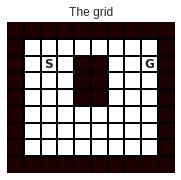

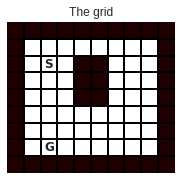

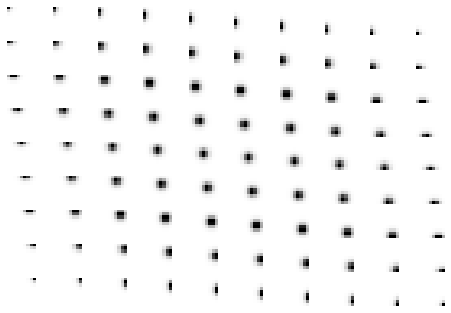

In [23]:
# Instantiate the two tabular environments
grid = Grid()
alt_grid = AltGrid()

# Plot tabular environments
grid.plot_grid()
alt_grid.plot_grid()

# Instantiate the non tabular version of the environment.
feat_grid = FeatureGrid()

# Plot the features of each state
shape = feat_grid._layout.shape
f, axes = plt.subplots(shape[0], shape[1])
for state_idx, ax in enumerate(axes.flatten()):
  ax.imshow(np.reshape((feat_grid.int_to_features(state_idx)[:-1]),(9,9)), interpolation='nearest')
  ax.set_xticks([])
  ax.set_yticks([])

# Helper functions

In [0]:
def run_experiment(env, agent, number_of_steps):
    mean_reward = 0.
    try:
      action = agent.initial_action()
    except AttributeError:
      action = 0
    for i in range(number_of_steps):
      reward, discount, next_state = env.step(action)
      action = agent.step(reward, discount, next_state)
      mean_reward += (reward - mean_reward)/(i + 1.)

    return mean_reward

map_from_action_to_subplot = lambda a: (2, 6, 8, 4)[a]
map_from_action_to_name = lambda a: ("up", "right", "down", "left")[a]

def plot_values(values, colormap='pink', vmin=-1, vmax=10):
  plt.imshow(values, interpolation="nearest", cmap=colormap, vmin=vmin, vmax=vmax)
  plt.yticks([])
  plt.xticks([])
  plt.colorbar(ticks=[vmin, vmax])

def plot_state_value(action_values):
  q = action_values
  fig = plt.figure(figsize=(4, 4))
  vmin = np.min(action_values)
  vmax = np.max(action_values)
  v = 0.9 * np.max(q, axis=-1) + 0.1 * np.mean(q, axis=-1)
  plot_values(v, colormap='summer', vmin=vmin, vmax=vmax)
  plt.title("$v(s)$")

def plot_action_values(action_values):
  q = action_values
  fig = plt.figure(figsize=(8, 8))
  fig.subplots_adjust(wspace=0.3, hspace=0.3)
  vmin = np.min(action_values)
  vmax = np.max(action_values)
  dif = vmax - vmin
  for a in [0, 1, 2, 3]:
    plt.subplot(3, 3, map_from_action_to_subplot(a))
    
    plot_values(q[..., a], vmin=vmin - 0.05*dif, vmax=vmax + 0.05*dif)
    action_name = map_from_action_to_name(a)
    plt.title(r"$q(s, \mathrm{" + action_name + r"})$")
    
  plt.subplot(3, 3, 5)
  v = 0.9 * np.max(q, axis=-1) + 0.1 * np.mean(q, axis=-1)
  plot_values(v, colormap='summer', vmin=vmin, vmax=vmax)
  plt.title("$v(s)$")
  
def random_policy(q):
  return np.random.randint(4)

def plot_greedy_policy(grid, q):
  action_names = [r"$\uparrow$",r"$\rightarrow$", r"$\downarrow$", r"$\leftarrow$"]
  greedy_actions = np.argmax(q, axis=2)
  grid.plot_grid()
  plt.hold('on')
  for i in range(9):
    for j in range(10):
      action_name = action_names[greedy_actions[i,j]]
      plt.text(j, i, action_name, ha='center', va='center')

# Part 1: Implement Agents

Each agent, should implement a step function:

### `__init__(self, number_of_actions, number_of_states, initial_observation)`:
The constructor will provide the agent the number of actions, number of states, and the initial observation. You can get the initial observation by first instatiating an environment, using `grid = Grid()`, and then calling `grid.get_obs()`.

All agents should be in pure Python - so you cannot use TensorFlow to, e.g., compute gradients.  Using `numpy` is fine.

### `step(self, reward, discount, next_observation, ...)`:
where `...` indicates there could be other inputs (discussed below).  The step should update the internal values, and return a new action to take.

When the discount is zero ($\text{discount} = \gamma = 0$), then the `next_observation` will be the initial observation of the next episode.  One shouldn't bootstrap on the value of this state, which can simply be guaranteed when using "$\gamma \cdot v(\text{next_observation})$" (for whatever definition of $v$ is appropriate) in the update, because $\gamma = 0$.  So, the end of an episode can be seamlessly handled with the same step function.

### `q_values()`:

Tabular agents implement a function `q_values()` returning a matrix of Q values of shape: (`number_of_states`, `number_of_actions`)

### `q_values(state)`:

Agents with Linear function approximation implement a method `q_values(state)` returning an array of Q values of shape: (`number_of_actions`)


### A note on the initial action
Normally, you would also have to implement a method that gives the initial action, based on the initial state.  As in the previous assignment you can use the action `0` (which corresponds to `up`) as initial action, so that otherwise we do not have to worry about this.  Note that this initial action is only executed once, and the beginning of the first episode---not at the beginning of each episode.

Q-learning and it's variants needs to remember the last action in order to update its value when they see the next state.  In the `__init__`, make sure you set the initial action to zero, e.g.,
```
def __init__(...):
  (...)
  self._action = 0
  (...)
```



# Part 1: Implement Agents

We are going to implement 5 agent:
- Online Tabular Q-learning
- Tabular Experience Replay
- Tabular Dyna-Q (with a Tabular model)
- Experience Replay with linear function approximation
- Dyna-Q with linear function approximation (with a linear model)



## 1.1 Tabular Model
**[5 pts]** Implement a trainable tabular Model of the environment.

The Model should implement: 
* a *next_state* method, taking a state and action and returning the next state in the environment.
* a *reward* method, taking a state and action and returning the immediate reward associated to execution that action in that state.
* a *discount* method, taking a state and action and returning the discount associated to execution that action in that state.
* a *transition* method, taking a state and an action and returning both the next state and the reward associated to that transition.
* a *update* method, taking a full transition *(state, action, reward, next_state)* and updating the model (in its reward, discount and next_state component)

Given that the environment is deterministic and tabular the model will basically reduce to a simple lookup table.

In [0]:
class TabularModel(object):

  def __init__(self, number_of_states, number_of_actions):
    self.table_discount = np.zeros((number_of_states, number_of_actions))
    self.table_reward = np.zeros((number_of_states, number_of_actions))
    self.table_next_state = np.zeros((number_of_states, number_of_actions))
  

  # return the next state in the environment
  def next_state(self, s, a):
    return self.table_next_state(s, a)
  
  # return the immediate reward
  def reward(self, s, a):
    return self.table_reward(s, a)

  # return the discount associated to execution that action in that state.
  def discount(self, s, a):
    return self.table_discount(s, a)
  
  # return both the next state and the reward associated to that transition.
  def transition(self, state, action):
    return (
        self.reward(state, action), 
        self.discount(state, action),
        self.next_state(state, action))
  
  def update(self, state, action, reward, discount, next_state):
    self.table_discount[state, action] = discount
    self.table_reward[state, action] = reward
    self.table_next_state[state, action] = next_state
  

## 1.2 Linear Model

**[5 pts]** Implement a trainable linear model of the environment.

The Model should implement: 
* a *next_state* method, taking a state and action and returning the predicted next state in the environment.
* a *reward* method, taking a state and action and returning the predicted immediate reward associated to execution that action in that state.
* a *discount* method, taking a state and action and returning the predicted discount associated to execution that action in that state.
* a *transition* method, taking a state and an action and returning both the next state and the reward associated to that transition.
* a *update* method, taking a full transition *(state, action, reward, next_state)* and updating the model (in its reward, discount and next_state component)

For each selected action, the predicted reward, discount and next state will all be a linear function of the state.
* $\text{s'} = T_a s$
* $\text{r'} = R_a s$
* $\text{g'} = G_a s$

Where $T_a$ is a matrix of shape $(\text{number_of_features}, \text{number_of_features})$, $R_a$ and $G_a$are vectors of shape $(\text{number_of_features},)$

The parameters of all these linear transformations must be trained by gradient descent. Write down the update to the parameters of the models and implement the update in the model below.

### Update of parameters:
Assuming the loss function is $J(\theta)$, $S'$ is the next state, $R$ is reward and $G$ is the discount gained from environment. Therefore, the loss function can be written as:

\\
$$J(T_a) = \frac{1}{2}(S' - T_a s)^2$$

\\

$$J(R_a) = \frac{1}{2}(R - R_a s)^2$$

\\
$$J(G_a) = \frac{1}{2}(G - G_a s)^2$$


\\
Therefore, the update equations of parameters are:



\\
$$ T_a = T_a - \alpha \Delta (T_a) = T_a - \alpha \frac{\partial J(T_a)}{\partial T_a}= T_a - \alpha (S' - T_a s) * -s$$



\\
$$ R_a = R_a - \alpha \Delta (R_a) = R_a - \alpha \frac{\partial J(R_a)}{\partial R_a}= R_a- \alpha (R - R_a s) * -s$$



\\
$$ G_a = G_a - \alpha \Delta (G_a) = G_a - \alpha \frac{\partial J(G_a)}{\partial G_a}= G_a- \alpha (G - G_a s) * -s$$ Where $\alpha$ is step_size



In [0]:
class LinearModel(object):

  def __init__(self, number_of_features, number_of_actions):
    self.T = np.zeros((number_of_features, number_of_features, number_of_actions))
    self.R = np.zeros((number_of_features, number_of_actions))
    self.G = np.zeros((number_of_features, number_of_actions))
    

  def next_state(self, s, a):
    return np.matmul(self.T[:,:,a], s)
  
  def reward(self, s, a):
    return np.matmul(self.R[:,a], s)

  def discount(self, s, a):
    return np.matmul(self.G[:,a], s)

  def transition(self, state, action):
    return (
        self.reward(state, action),
        self.discount(state, action),
        self.next_state(state, action))

  def update(self, state, action, reward, discount, next_state, step_size=0.1):
    self.T[:,:,action] -= step_size * np.dot(np.reshape((next_state - 
           np.dot(self.T[:, :, action], state)), [-1, 1]), np.reshape(-state, [1, -1]))
    self.R[:, action] -= step_size * ((reward - np.dot(self.R[:, action], state)) * -state)
    self.G[:, action] -= step_size * ((discount - np.dot(self.G[:, action], state)) * -state)
 

## 1.3 Experience Replay

**[10 pts]** Implement an agent that uses **Experience Replay** to learn action values, at each step:
* select actions randomly
* accumulate all observed transitions *(s, a, r, s')* in the environment in a *replay buffer*,
* apply an online Q-learning 
* apply multiple Q-learning updates based on transitions sampled (uniformly) from the *replay buffer* (in addition to the online updates).

**Initialize** $Q(s, a)$ and $\text{Model}(s, a)$ for all s ∈ S and a ∈ A(s)

**Loop forever**:

1. $S \gets{}$current (nonterminal) state
 
2. $A \gets{} \text{random_action}(S)$
 
3. Take action $A$; observe resultant reward $R$, discount $\gamma$, and state, $S'$

4. $Q(S, A) \gets Q(S, A) + \alpha (R + \gamma \max_a Q(S', a) − Q(S, A))$

5. $\text{ReplayBuffer}.\text{append_transition}(S, A, R, \gamma, S')$

6. Loop repeat n times:

  1. $S, A, R, \gamma, S' \gets \text{ReplayBuffer}.\text{sample_transition}()$
  
  4. $Q(S, A) \gets Q(S, A) + \alpha (R + \gamma \max_a Q(S', a) − Q(S, A))$

In [0]:
#@title  { display-mode: "code" }
 class ExperienceQ(object):

  def __init__(
      self, number_of_states, number_of_actions, initial_state, 
      behaviour_policy, num_offline_updates=0, step_size=0.1):
    
    self.q_value = np.zeros((number_of_states, number_of_actions))
    self._state = initial_state
    self.step_size = step_size
    self._action = 0
    self.behaviour_policy = behaviour_policy
    self.relpay_buffer = []
    self.num_offline_updates = num_offline_updates
    
  @property
  def q_values(self):
    return self.q_value
  
  def step(self, reward, discount, next_state):
    s = self._state
    a = self._action
    r = reward
    g = discount
    next_s = next_state
    
    self._action = self.behaviour_policy(self._state)
    
    # update action value
    self.q_value[s, a] += self.step_size * (r + g * np.max(self.q_value[next_s, :]) - self.q_value[s, a])
    
    # refresh replay buffer
    self.relpay_buffer.append((s, a, r, g, next_s))
    
    for i in range(self.num_offline_updates):
      sample_index = np.random.choice(len(self.relpay_buffer))
      s_, a_, r_, g_, next_s_ = self.relpay_buffer[sample_index]
      self.q_value[s_,a_] += self.step_size * (r_ + g_ * np.max(self.q_value[next_s_, :]) - self.q_value[s_, a_])

    
    self._state = next_state
    
    return self._action


## 1.4 Dyna-Q
**[10 pts]** Implement an agent that uses **Dyna-Q** to learn action values.  
* select actions randomly
* accumulate all observed transitions *(s, a, r, s')* in the environment in a *replay buffer*,
* apply an online Q-learning to Q-value
* apply an update to the *model* based on the latest transition
* apply multiple Q-learning updates based on transitions *(s, a, model.reward(s), model.next_state(s))* for some previous state and action pair *(s, a)*.

**Initialize** $Q(s, a)$ and $\text{Model}(s, a)$ for all s ∈ S and a ∈ A(s)

**Loop forever**:

1. $S \gets{}$current (nonterminal) state
 
2. $A \gets{} \text{random_action}(S)$
 
3. Take action $A$; observe resultant reward $R$, discount $\gamma$, and state, $S'$

4. $Q(S, A) \gets Q(S, A) + \alpha (R + \gamma \max_a Q(S', a) − Q(S, A))$

5. $\text{ReplayBuffer}.\text{append_transition}(S, A)$

6. $\text{Model}.\text{update}(S, A, R, \gamma, S')$

6. Loop repeat n times:

  1. $S, A \gets \text{ReplayBuffer}.\text{sample_transition}()$
  
  2. $R, \gamma, S' \gets \text{Model}.\text{transition}(S, A)$
  
  3. $Q(S, A) \gets Q(S, A) + \alpha (R + \gamma \max_a Q(S', a) − Q(S, A))$

In [0]:
class DynaQ(object):

  def __init__(
      self, number_of_states, number_of_actions, initial_state, 
      behaviour_policy, num_offline_updates=0, step_size=0.1):
    
    self.q_value = np.zeros((number_of_states, number_of_actions))
    self._state = initial_state
    self.step_size = step_size
    self._action = 0
    self.behaviour_policy = behaviour_policy
    self.relpay_buffer = []
    self.num_offline_updates = num_offline_updates
    self.model_transition = {}
    
  @property
  def q_values(self):
    return self.q_value

  def step(self, reward, discount, next_state):
    s = self._state
    a = self._action
    r = reward
    g = discount
    next_s = next_state
    
    self._action = self.behaviour_policy(self._state)
    
    # update action value
    self.q_value[s, a] += self.step_size * (r + g * np.max(self.q_value[next_s, :]) - self.q_value[s, a])
    
    # refresh replay buffer
    self.relpay_buffer.append((s, a))
    self.model_transition[(s, a)] = [r, g, next_s]   
    
    for i in range(self.num_offline_updates):
      sample_index = np.random.choice(len(self.relpay_buffer))
      s_, a_ = self.relpay_buffer[sample_index]
      r_, g_, next_s_ = self.model_transition[(s_, a_)]
      self.q_value[s_,a_] += self.step_size * (r_ + g_ * np.max(self.q_value[next_s_, :]) - self.q_value[s_, a_])

    
    self._state = next_state
    
    return self._action

## 1.5 Experience Replay with Linear Function Approximation

**[10 pts]** Implement an agent that uses **Experience Replay** to learn action values as a linear function approximation over a given set of features.

**Training**: To make sure of the experience in an online fashion, we will learn this linear model via gradient descent. Write down the update to the parameters of the value function and implement the update in the agent below.

In [0]:
class FeatureExperienceQ(ExperienceQ):

  def __init__(
      self, number_of_features, number_of_actions, *args, **kwargs):
    super(FeatureExperienceQ, self).__init__(
        number_of_actions=number_of_actions, *args, **kwargs)
    self.number_of_features = number_of_features
    self.number_of_actions = number_of_actions
    self.parameter = np.zeros((number_of_actions, number_of_features))
   
  def q(self, state):
    return np.dot(self.parameter, state)

  def step(self, reward, discount, next_state):
    s = self._state
    a = self._action
    r = reward
    g = discount
    next_s = next_state
    
    """Update action value"""
    # Update next action
    self._action = self.behaviour_policy(self._state)
    
    q_action = np.matmul(self.parameter[a, :], s)
    q_next_state = np.amax(np.matmul(self.parameter, next_s))
    delta = r + g * q_next_state - q_action
    self.parameter[a, :] += self.step_size * delta * s

    # refresh replay buffer
    self.relpay_buffer.append((s, a, r, g, next_s))
    
    for i in range(self.num_offline_updates):
      sample_index = np.random.choice(len(self.relpay_buffer))
      s_, a_, r_, g_, next_s_ = self.relpay_buffer[sample_index]
     
      _q_action = np.matmul(self.parameter[a_, :], s_)
      _q_next_state = np.amax(np.matmul(self.parameter, next_s_))
      _delta = r_ + g_ * _q_next_state - _q_action
      self.parameter[a_, :] += self.step_size * _delta * s_
      

    self._state = next_state
    
    return self._action


## 1.6 Dyna-Q with Linear Function Approximation

**[10 pts]** Implement an agent that uses **Dyna-Q** that uses a linear function approximation to represent the value functions and a learnt linear model of the environment (represent and learn both the **transition model**(action conditioned) and the **reward model** as linear transformations of the given set of features).  
* select actions randomly
* accumulate all observed transitions *(s, a, r, s')* in the environment in a *replay buffer*,
* apply an online Q-learning to Q-value
* apply an update to the *model* based on the latest transition, use a step_size of 0.01
* apply multiple Q-learning updates based on transitions *(s, a, model.reward(s), model.next_state(s))* for some previous state and action pair *(s, a)*.

**Initialize** $Q(s, a)$ and $\text{Model}(s, a)$ for all s ∈ S and a ∈ A(s)

**Loop forever**:

1. $S \gets{}$current (nonterminal) state
 
2. $A \gets{} \text{random_action}(S)$
 
3. Take action $A$; observe resultant reward $R$, discount $\gamma$, and state, $S'$

4. $Q(S, A) \gets Q(S, A) + \alpha (R + \gamma \max_a Q(S', a) − Q(S, A))$

5. $\text{ReplayBuffer}.\text{append_transition}(S, A)$

6. $\text{Model}.\text{update}(S, A, R, \gamma, S')$

6. Loop repeat n times:

  1. $S, A \gets \text{ReplayBuffer}.\text{sample_transition}()$
  
  2. $R, \gamma, S' \gets \text{Model}.\text{transition}(S, A)$
  
  3. $Q(S, A) \gets Q(S, A) + \alpha (R + \gamma \max_a Q(S', a) − Q(S, A))$

In [0]:
class FeatureDynaQ(DynaQ):

  def __init__(self, number_of_features, number_of_actions, *args, **kwargs):
    super(FeatureDynaQ, self).__init__(
        number_of_actions=number_of_actions, *args, **kwargs)
    self.number_of_features = number_of_features
    self.number_of_actions = number_of_actions
#     self.parameter = np.zeros((number_of_actions, number_of_features))
    self.parameter = np.random.rand(number_of_actions, number_of_features)
    self.model = LinearModel(number_of_features, number_of_actions)

  def q(self, state):
    return np.dot(self.parameter, state)

  def step(self, reward, discount, next_state):
    s = self._state
    a = self._action
    r = reward
    g = discount
    next_s = next_state
    
    """Update action value"""
    # Update next action
    self._action = self.behaviour_policy(self._state)

    q_action = np.matmul(self.parameter[a, :], s)
    q_next_state = np.amax(np.matmul(self.parameter, next_s))
    delta = r + g * q_next_state - q_action
    self.parameter[a, :] += self.step_size * delta * s
    
    # refresh replay buffer
    self.relpay_buffer.append((s, a))
    self.model.update(s, a, r, g, next_s)
    
    for i in range(self.num_offline_updates):
      sample_index = np.random.choice(len(self.relpay_buffer))
      s_, a_ = self.relpay_buffer[sample_index]
      r_, g_, next_s_ = self.model.transition(s_, a_)
      
      _q_action = np.matmul(self.parameter[a_, :], s_)
      _q_next_state = np.amax(np.matmul(self.parameter, next_s_))
      _delta = r_ + g_ * _q_next_state - _q_action 
      self.parameter[a_, :] += self.step_size * _delta * s_ 
    
    self._state = next_state
    
    return self._action

# Assignment 2: Analyse Results

## 2.1 Tabular Learning

### 2.1.1 Data Efficiency

**Online Q-learning**

* $\text{number_of_steps}$ = $1e3$ and $\text{num_offline_updates}$ = $0$

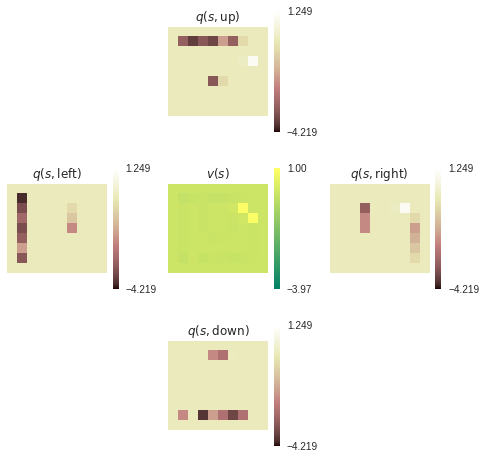

In [31]:
grid = Grid()
agent = ExperienceQ(
  grid._layout.size, 4, grid.get_obs(),
  random_policy, num_offline_updates=0, step_size=0.1)
run_experiment(grid, agent, int(1e3))
q = agent.q_values.reshape(grid._layout.shape + (4,))
plot_action_values(q)

**Experience Replay**

* $\text{number_of_steps}$ = $1e3$ and $\text{num_offline_updates}$ = $0$

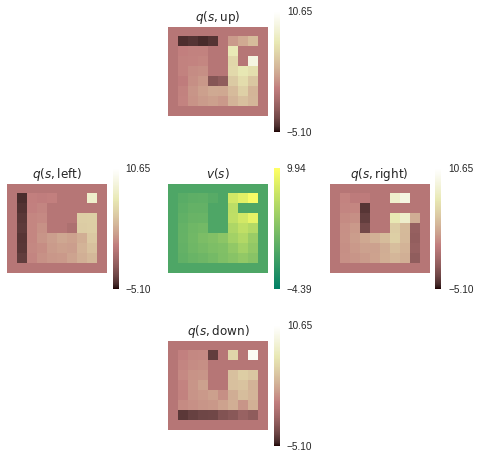

In [46]:
grid = Grid()
agent = ExperienceQ(
  grid._layout.size, 4, grid.get_obs(),
  random_policy, num_offline_updates=30, step_size=0.1)
run_experiment(grid, agent, int(1e3))
q = agent.q_values.reshape(grid._layout.shape + (4,))
plot_action_values(q)

**DynaQ**

* $\text{number_of_steps}$ = $1e3$ and $\text{num_offline_updates}$ = $30$

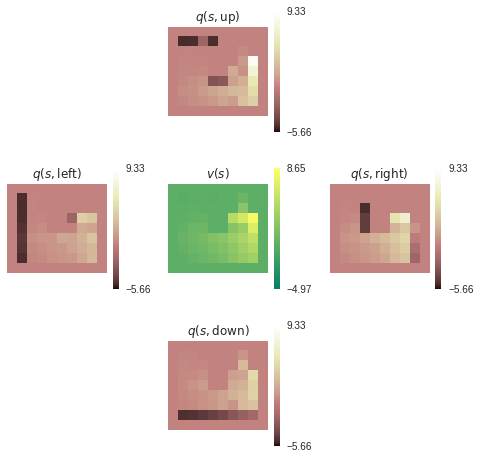

In [47]:
grid = Grid()
agent = DynaQ(
  grid._layout.size, 4, grid.get_obs(),
  random_policy, num_offline_updates=30, step_size=0.1)
run_experiment(grid, agent, int(1e3))
q = agent.q_values.reshape(grid._layout.shape + (4,))
plot_action_values(q)

### 2.1.2 Computational Cost

What if sampling from the environment is cheap and I don't care about data efficiency but only care about the number of updates to the model?

How do Online Q-learning, ExperienceReplay and Dyna-Q compare if I apply the same number of total updates?

**Online Q-learning**

* $\text{number_of_steps}$ = $3e4$ and $\text{num_offline_updates}$ = $0$



/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:58: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.


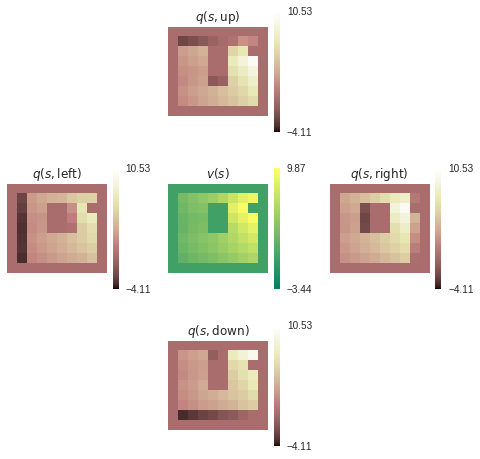

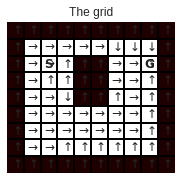

In [48]:
grid = Grid()
agent = ExperienceQ(
  grid._layout.size, 4, grid.get_obs(),
  random_policy, num_offline_updates=0, step_size=0.1)
run_experiment(grid, agent, int(3e4))
q = agent.q_values.reshape(grid._layout.shape + (4,))
plot_action_values(q)
plot_greedy_policy(grid, q)

**ExperienceReplay**

* $\text{number_of_steps}$ = $1e3$ and $\text{num_offline_updates}$ = $30$

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:58: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.


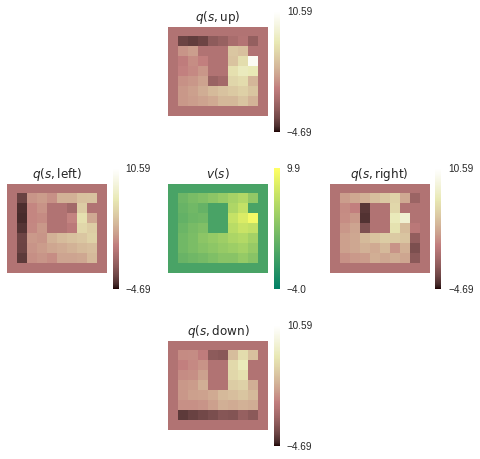

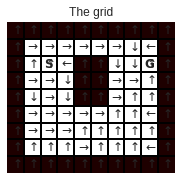

In [49]:
grid = Grid()
agent = ExperienceQ(
  grid._layout.size, 4, grid.get_obs(),
  random_policy, num_offline_updates=30, step_size=0.1)
run_experiment(grid, agent, int(1e3))
q = agent.q_values.reshape(grid._layout.shape + (4,))
plot_action_values(q)
plot_greedy_policy(grid, q)

**DynaQ**

* $\text{number_of_steps}$ = $1e3$ and $\text{num_offline_updates}$ = $30$

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:58: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.


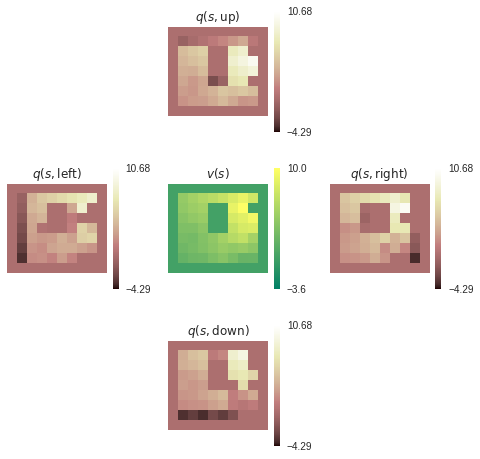

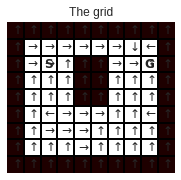

In [50]:
grid = Grid()
agent = DynaQ(
  grid._layout.size, 4, grid.get_obs(),
  random_policy, num_offline_updates=30, step_size=0.1)
run_experiment(grid, agent, int(1e3))
q = agent.q_values.reshape(grid._layout.shape + (4,))
plot_action_values(q)
plot_greedy_policy(grid, q)

## 2.3 Linear function approximation

We will now consider the $\text{FeatureGrid}$ domain.

And evaluate $\text{Q-learning}$, $\text{Experience Replay}$ and $\text{DynaQ}$, in the context of linear function approximation.

All experiments are run for $\text{number_of_steps}$ = $1e5$

**Online Q-learning with Linear Function Approximation**

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:58: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.


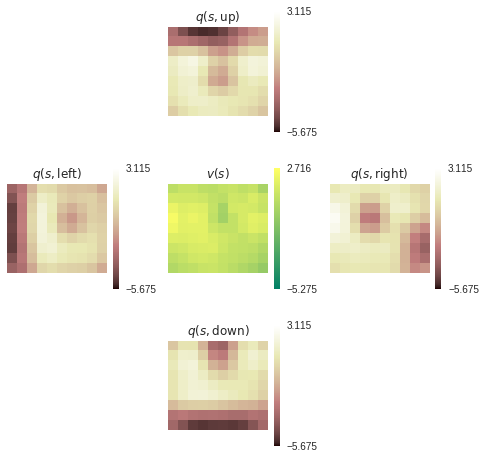

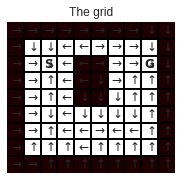

In [37]:
grid = FeatureGrid()

agent = FeatureExperienceQ(
  number_of_features=grid.number_of_features, number_of_actions=4,
  number_of_states=grid._layout.size, initial_state=grid.get_obs(),
  num_offline_updates=0, step_size=0.01, behaviour_policy=random_policy)
run_experiment(grid, agent, int(1e5))
q = np.reshape(
    np.array([agent.q(grid.int_to_features(i)) for i in range(grid.number_of_states)]),
    [grid._layout.shape[0], grid._layout.shape[1], 4])
plot_action_values(q)
plot_greedy_policy(grid, q)

Experience Replay with Linear Function Approximation**

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:58: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.


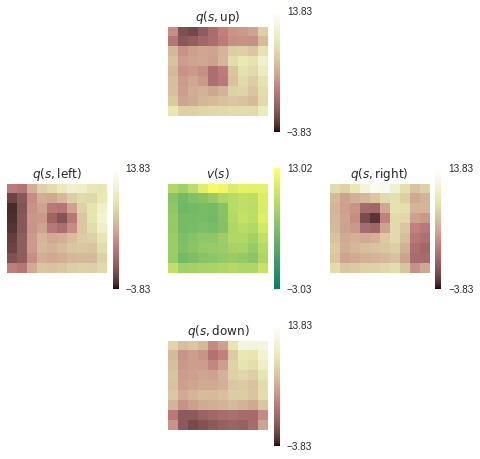

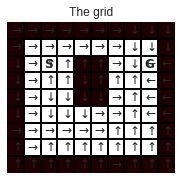

In [38]:
grid = FeatureGrid()

agent = FeatureExperienceQ(
  number_of_features=grid.number_of_features, number_of_actions=4,
  number_of_states=grid._layout.size, initial_state=grid.get_obs(),
  num_offline_updates=10, step_size=0.01, behaviour_policy=random_policy)
run_experiment(grid, agent, int(1e5))
q = np.reshape(
    np.array([agent.q(grid.int_to_features(i)) for i in range(grid.number_of_states)]),
    [grid._layout.shape[0], grid._layout.shape[1], 4])
plot_action_values(q)
plot_greedy_policy(grid, q)

**DynaQ with Linear Function Approximation**

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:58: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.


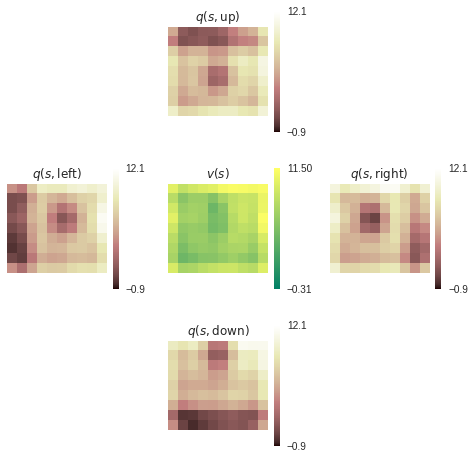

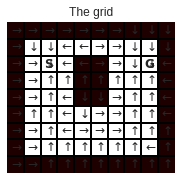

In [45]:
grid = FeatureGrid()

agent = FeatureDynaQ(
  number_of_features=grid.number_of_features, 
  number_of_actions=4,
  number_of_states=grid._layout.size, 
  initial_state=grid.get_obs(),
  num_offline_updates=10, 
  step_size=0.01,
  behaviour_policy=random_policy)

run_experiment(grid, agent, int(1e5))
q = np.reshape(
    np.array([agent.q(grid.int_to_features(i)) for i in range(grid.number_of_states)]),
    [grid._layout.shape[0], grid._layout.shape[1], 4])
plot_action_values(q)
plot_greedy_policy(grid, q)

## 2.4 Non stationary Environments

We now consider a non-stationary setting where after `pretrain_steps` in the environment, the goal is moved to a new location (from the top-right of the grid to the bottom-left).

The agent is allowed to continue training for a (shorter) amount of time in this new setting, and then we evaluate the value estimates.

In [0]:
pretrain_steps = 2e4
new_env_steps = pretrain_steps / 30

**Online Q-learning**

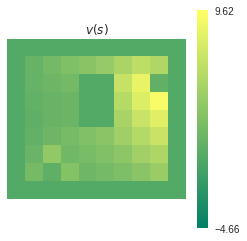

In [41]:
# Train on first environment
grid = Grid()
agent = ExperienceQ(
  grid._layout.size, 4, grid.get_obs(),
  random_policy, num_offline_updates=0, step_size=0.1)
run_experiment(grid, agent, int(pretrain_steps))
q = agent.q_values.reshape(grid._layout.shape + (4,))
# plot_state_value(q)

# Change goal location
alt_grid = AltGrid()
run_experiment(alt_grid, agent, int(new_env_steps))
alt_q = agent.q_values.reshape(alt_grid._layout.shape + (4,))
plot_state_value(alt_q)

**Experience Replay**

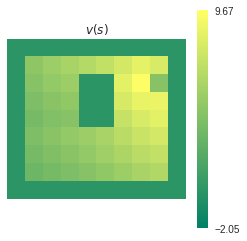

In [42]:
# Train on first environment
grid = Grid()
agent = ExperienceQ(
  grid._layout.size, 4, grid.get_obs(),
  random_policy, num_offline_updates=30, step_size=0.1)
run_experiment(grid, agent, int(pretrain_steps))
q = agent.q_values.reshape(grid._layout.shape + (4,))
# plot_state_value(q)

# Change goal location
alt_grid = AltGrid()
run_experiment(alt_grid, agent, int(new_env_steps))
alt_q = agent.q_values.reshape(alt_grid._layout.shape + (4,))
plot_state_value(alt_q)

**Dyna**

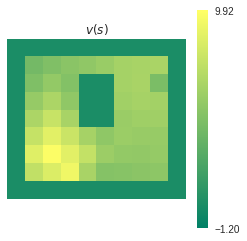

In [43]:
# Train on first environment
grid = Grid()
agent = DynaQ(
  grid._layout.size, 4, grid.get_obs(),
  random_policy, num_offline_updates=30, step_size=0.1)
run_experiment(grid, agent, int(pretrain_steps))
q = agent.q_values.reshape(grid._layout.shape + (4,))
# plot_state_value(q)

# Change goal location
alt_grid = AltGrid()
run_experiment(alt_grid, agent, int(new_env_steps))
alt_q = agent.q_values.reshape(alt_grid._layout.shape + (4,))
plot_state_value(alt_q)

## Questions

### Basic Tabular Learning

**[5 pts]** Why is the ExperienceReplay agent so much more data efficient than online Q-learning?

Answer: 

    ExperienceReplay agent use previous experience, and learn with it multiple times. This is key when gaining experience is costly, you can get full use of it. The Q-learning updates are incremental and do not converge quickly, so multiple passes with the same data is beneficial, especially when there is low variance in immediate outcomes (reward, next state) given the same state, action pair.

**[5 pts]** If we run the experiments for the same number of updates, rather than the same number of steps in the environment, which among online Q-learning and Experience Replay performs better? Why?

Answer: 

    When the number of updates is same, online Q-learning will perform better.
    
    For online Q-learning, it update once per step, and it always update the latest experience. For experience Replay, it learnt old experience many times in one step. If the number of update is same, online Q-learning can have more steps, and it means it can not have more experience, so it perform better than experience replay.

**[5 pts]** Which among online Q-learning and Dyna-Q is more data efficient? why?

Answer: 
    
    Dyna-Q have more data efficient.

    Dyna-Q  agent use previous experience, and learn with it multiple times. The difference between Dyna-Q and experience replay is the value in transition of Dyna-Q will update if new experience input. The Q-learning updates are incremental and do not converge quickly, so multiple passes with the same data is beneficial, especially when there is low variance in immediate outcomes (reward, next state) given the same state, action pair.

**[5 pts]** If we run the experiments for the same number of updates, rather than the same number of steps in the environment, which among online Q-learning and Dyna-Q performs better? Why?

Answer: 

    When the number of updates is same, online Q-learning will perform better. Although Dyna-Q  perform good, but it is not stable, whereas online Q-learning is good and stable.
    
    For online Q-learning, it update once per step, and it always update the latest experience, so it is incremental. For Dyna-Q, it learnt old experience many times in one step. It update transition  when replay bufffer update. However, if the number of update is same, online Q-learning can have more steps, and it means it can not have more experience, and it may cause part of action value converge quickly, but it is not stable for training process.

### Linear function approximation

**[5 pts]** The value estimates with function approximation are considerably more blurry than in the tabular setting despite more training steps and interactions with the environment, why is this the case?

Answer: 

    When the value estimates with function approximation, the predicted reward, discount and next state will all be a linear function of the state. However, in the real world, predicted reward, discount and next state may be non-linear model, and Our feature selection is not perfect to provide enough information and can not perfectly represent each state, so linear function can not converge action value exactly, so the lineae model is more blurry than the tabublar model. 

**[5 pts]** Inspect the policies derived by training agents with linear function approximation on `FeatureGrid` (as shown by `plot_greedy_policy`). How does this compare to the optimal policy? Are there any inconsistencies you can spot? What is the reason of these?

Answer:

    It is obvious that the policy does not converge to the optimal policy. Even near the goal location, the policy shows wrong action. Becasuse the approximation accuracy is fundamentally limited by the information provided by the features. Hence, the feature selection is not perfect to provide enough information and can not perfectly represent each state.

### Learning in a non stationary environment

Consider now the tabular but non-stationary setting of section 2.4.

After an initial pretraining phase, the goal location is moved to a new location, where the agent is allowed to train for some (shorter) time.

**[10 pts]** Compare the value estimates of online Q-learning and Experience Replay, after training also on the new goal location, explain what you see.

Answer:

    Compare the value estimates of online Q-learning and Experience Replay, although both  online Q-learning and Experience Replay perform bad when the goal moved to a new location, but online Q-learning perform better. 
    
    For online q-learning, it can be found that the action values around of new goal location has increased sightly. The Q-learning updates are incremental and do not converge quickly, and it update once in per step. Shorter time is not enough for Q-learning to find a new goal, and it did not converge as well. 
    
    For experience Replay, the action value figure almost same as before (no new goal added). In training process(old goal), the replay buffer keep adding new experience. After goal location moving to new location, there are too much old experience in replay buffer. Hence, in short training time, replay buffer just have few new exprience(to new goal). In the loop repeat, the training data (random in replay buffer) lead the action value to old goal because of very litte new experience in replay buffer. 

**[10 pts]** Compare the value estimates of online Q-learning and Dyna-Q, after training also on the new goal location, explain what you see.

Back up your observations with visualizations of the value/policy.

Answer:

    Compare the value estimates of online Q-learning and Dyna-Q, Dyna-Q perform better. 
    
    For online q-learning, it can be found that the action values around of new goal location has increased sightly. The Q-learning updates are incremental and do not converge quickly, and it update once in per step. Shorter time is not enough for Q-learning to find a new goal, and it did not converge as well. 
    
    For Dyna-Q, the action values around new goal have high values. In training process, although the replay buffer keep adding new experience, the transition will update discount, reward and next_state if same state and action are added in replay buffer, so Dyna-Q always learning the latest experience from model. After goal location moving to new location, when new expericence (new goal) add in replay buffer, the old experience (old goal) will be updated. In each step, the repeat loop update the action value, so the result is acceptable.
    

